# **Libraries**

In [ ]:
import numpy as np
import math
from math import log, log10
import matplotlib
import matplotlib.pyplot as plt
import PIL                                    # Python Imaging Library
from PIL import Image
import time
import os
import glob

# **Data Loader**



In [ ]:
def DataLoader(folder_path):
  data_list = []
  for img_path in glob.glob(os.path.join(folder_path + "*.jpg")):
    img = Image.open(img_path)
    cropped_blocks_arr = AutoencoderMLP.MoveWindow(img, 8)
    blocks_pixels = cropped_blocks_arr.reshape(-1,int(cropped_blocks_arr.shape[1]*cropped_blocks_arr.shape[2]))
    pixel_list = []
    for row_pixels in blocks_pixels:
        row_pixels = np.array(row_pixels)
        row_values = row_pixels.astype('float32')/255
        pixel_list.append(row_values)

    data_list.append(np.array(pixel_list))
  return np.array(data_list)

# **Activation function & it's derivative**

In [ ]:
# In Python to write classes
# where the instances behave like functions
# and can be called like a function

class Sigmoid():

    def __call__(self, x):                                # obj_name = cls_name() where ever I use "obj_name()"
        return 1 / (1 + np.exp(-x))                       # the call method will be activated (no need for ths format: objname.methodname())
    def gradient(self, x):                                # func = Sigmoid()  ------>  func(0) = 0.5
        return self.__call__(x) * (1 - self.__call__(x))

# **MLP model**

In [ ]:
class AutoencoderMLP():
    def __init__(self, n_input, n_hidden, n_output, alpha=0.001, optimizer=None, mu=0.8):

        self.n_hidden = n_hidden
        self.n_input = n_input
        self.alpha = alpha
        self.mu = mu
        self.hidden_activation = Sigmoid()        # hidden_activation obj attribute himself is an obj from sigmoid class
        self.output_activation = Sigmoid()
        self.optimizer = optimizer

       # Initializing the weights
        # Hidden layer
        limit   = 1 / math.sqrt(n_input)
        self.W  = np.random.uniform(-limit, limit, (n_input, self.n_hidden))
        self.w0 = np.random.uniform(-limit, limit, (1, self.n_hidden))

        # Output layer
        limit   = 1 / math.sqrt(self.n_hidden)
        self.V  = np.random.uniform(-limit, limit, (self.n_hidden, n_output))
        self.v0 = np.random.uniform(-limit, limit, (1, n_output))

        # initial Delta weights and biases: momentum = 0
        self.Delta_V = np.zeros((self.n_hidden, n_output))
        self.Delta_W = np.zeros((n_input, self.n_hidden))
        self.Delta_w0 = np.zeros((1,self.n_hidden ))
        self.Delta_v0 = np.zeros((1, n_output))


    def MSE(self, actual, predicted):
        predicted = np.clip(predicted, 1e-15, 1 - 1e-15)        # change min predicted value (0) to 10^-15
        sigma_SE = np.sum(np.power(actual - predicted,2))
        Mean_SE = (1.0 / (2*len(actual))) * sigma_SE            # 1/2n(sigma_SE)
        return Mean_SE

    def PSNR(self, actual, predicted):
      return 10*np.log10(1**2/self.MSE(actual, predicted))


    @classmethod
    def MoveWindow(cls, img, w):                                 # w=8  window non-overlap
        img_array = np.array(img)
        x, y = img_array.shape                                   # image dimention: 256*256
        blocks_list = []                                         # 8*8 pixels list
        for i in range(0, x, w):                                 # (0,256,8)
            for j in range(0, y, w):
                block = (i, j, i+w, j+w)                         # block indeces: moves the block on the image and crops it via indeces
                cropped_block = img.crop(block)                  # block moving: horizontal then vertical
                block_array = np.array(cropped_block)
                blocks_list.append(block_array)
        blocks_array = np.array(blocks_list)
        return blocks_array

    def Reconstitution_img(self, pred_values):                       # Reshaping all pix as (256*256) image
        pred_values = np.array(pred_values)
        pred_pixels = (pred_values*255).astype(np.uint8)
        pred_blocks = pred_pixels.reshape(-1, 8, 8)
        img_block_list = list(range(32))                             # initailize a list with 32 elements
        for i in range(32):
            img_block_list[i] = np.vstack(pred_blocks[32*i : 32*(i+1)])
        img = np.hstack(img_block_list[:])
        return img

    def PSNRperEPOCH(self,epoch, psnr_list):
        plt.plot(range(1, epoch+1), psnr_list)
        plt.xlabel('Epoch')
        plt.ylabel('PSNR')
        plt.show()

    def ShowResultImages(self, eval_info_list):
        print('              Real                           predicted')
        for eval_info in eval_info_list:
          # print(eval_info)
          x, y_pred, img_PSNR, img_MSE =  eval_info
          img = Image.fromarray(self.Reconstitution_img(x))
          pred_img = Image.fromarray(self.Reconstitution_img(y_pred))
          # plt.plot(pred_img)
          board = Image.new('L', (img.width + pred_img.width, img.height))
          board.paste(img, (0, 0))
          board.paste(pred_img, (img.width, 0))
          display(board)
          print("----------   PSNR:",img_PSNR)
          print()

    def ForwardBackward(self, X, y):
        # .............
        #  Feedforward
        # ......\/.....
        # HIDDEN LAYER                                                                  # X = X.reshape(64, 1)    1*64
        hidden_input = np.dot(X, self.W) + self.w0
        hidden_output = self.hidden_activation(hidden_input)
        # OUTPUT LAYER
        output_layer_input = np.dot(hidden_output, self.V) + self.v0
        y_pred = self.output_activation(output_layer_input)                              #1*64

        # ...............
        #  Backpropagation
        # .......\/.......
        # OUTPUT LAYER
        delta_v = (y - y_pred)*self.output_activation.gradient(output_layer_input)       #1*64
        # HIDDEN LAYER
        delta_in = np.dot(delta_v, self.V.T)                                             #self.wT
        delta_w = delta_in*self.hidden_activation.gradient(hidden_input)

        if self.optimizer == 'SGD':
            # Update weights (by gradient descent)
            self.V += self.alpha * np.dot(hidden_output.T, delta_v)                      #hidden_output.shape: 1*32
            self.v0 += self.alpha * delta_v
            X = X.reshape(64, 1)                                                         #XT
            self.W += self.alpha * np.dot(X, delta_w)
            self.w0 += self.alpha * delta_w

        elif self.optimizer == 'momentum':
            X = X.reshape(64, 1)
            # Update weights and biases (by momentum)
            self.Delta_V = self.mu*self.Delta_V + self.alpha * np.dot(hidden_output.T, delta_v)
            self.Delta_W = self.mu*self.Delta_W + self.alpha * np.dot(X, delta_w)                # DeltaW = DeltaW(t-1) + DeltaW(t)
            self.Delta_w0 = self.mu*self.Delta_w0 + self.alpha * delta_w
            self.Delta_v0 = self.mu*self.Delta_v0 + self.alpha * delta_v

            self.V +=  self.Delta_V
            self.v0 += self.Delta_v0

            self.W += self.Delta_W
            self.w0 += self.Delta_w0
        else:
            print("optimizer is not defined!")

    def train(self, X, max_epochs=100, Mean_PSNR_minChange = 0.3, Mean_PSNR_Max = 40):
      previous_psnr = 0.0
      mean_psnr_list = []
      start_time = time.time()
      # n_imgs = X.shape[0]
      merged_imgs_blocks_values = X.reshape(-1,X.shape[2])

      for epoch in range(1,max_epochs+1):
        for x in merged_imgs_blocks_values:
          self.ForwardBackward(x, x)

        Mean_PSNR, Mean_MSE, eval_info_list = self.evaluate(X)

        mean_psnr_list.append(Mean_PSNR)
        Mean_PSNR_change = Mean_PSNR - previous_psnr

        print(f'--------------------------Mean PSNR of all images in epoch - {epoch} : {Mean_PSNR}-----------------------------------')
        print(f'------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - {epoch} : {Mean_MSE}------------------')
        print(f'psnr change after an epoch (psnr - previous_psnr =): {Mean_PSNR_change}')
        print()
        print(f"sample for epoch - {epoch}")
        self.ShowResultImages([eval_info_list[0]])
        #----------check the stop conditions--------
        if (Mean_PSNR_change) < Mean_PSNR_minChange:
          print('No considerable change!')
          self.PSNRperEPOCH(epoch,mean_psnr_list)
          break

        elif (Mean_PSNR) > Mean_PSNR_Max:
          print('Well enough')
          self.PSNRperEPOCH(epoch,mean_psnr_list)
          break

        elif epoch==max_epochs:
          self.PSNRperEPOCH(epoch,mean_psnr_list)

        else:
          previous_psnr = Mean_PSNR.copy()

      print()
      print('*******************End of epochs*********************')
      print('Durationt: ',time.time() - start_time,' seconds')
      print()

    def predict(self, X):
        # Forward pass:
        hidden_input = np.dot(X, self.W) + self.w0
        hidden_output = self.hidden_activation(hidden_input)
        output_layer_input = np.dot(hidden_output, self.V) + self.v0
        y_pred = self.output_activation(output_layer_input)
        return y_pred

    def evaluate(self, X):
      n_imgs = X.shape[0]
      eval_info_list = []
      sum_PSNR = 0.
      sum_MSE = 0.
      for x in X:
        y_pred = self.predict(x)
        y_pred_vec = y_pred.reshape(-1)
        x_vec = x.reshape(-1)
        img_PSNR = self.PSNR(x_vec, y_pred_vec)
        img_MSE = self.MSE(x_vec, y_pred_vec)
        sum_PSNR += img_PSNR
        sum_MSE += img_MSE
        eval_info_list.append((x, y_pred, img_PSNR, img_MSE))
      return sum_PSNR/n_imgs, sum_MSE/n_imgs, eval_info_list

In [ ]:
train_folder_path = "/content/train/"
test_folder_path = "/content/test/"

X_train = DataLoader(train_folder_path)
X_test = DataLoader(test_folder_path)

In [ ]:
# Optimizer: SGD

# **Optimizer: SGD**

---



## **Training & testing model with 32 hidden nerouns**

--------------------------Mean PSNR of all images in epoch - 1 : 25.57120689930417-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 1 : 0.0038754963458694836------------------
psnr change after an epoch (psnr - previous_psnr =): 25.57120689930417

sample for epoch - 1
              Real                           predicted


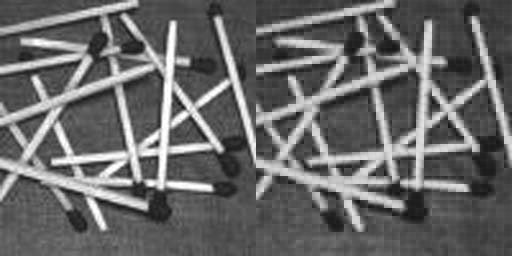

----------   PSNR: 25.66321518693112

--------------------------Mean PSNR of all images in epoch - 2 : 27.650337753236503-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 2 : 0.002581853015276214------------------
psnr change after an epoch (psnr - previous_psnr =): 2.079130853932334

sample for epoch - 2
              Real                           predicted


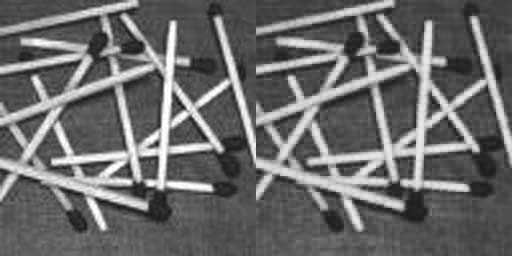

----------   PSNR: 29.6608495616427

--------------------------Mean PSNR of all images in epoch - 3 : 28.356073959832482-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 3 : 0.0022406756893941704------------------
psnr change after an epoch (psnr - previous_psnr =): 0.7057362065959794

sample for epoch - 3
              Real                           predicted


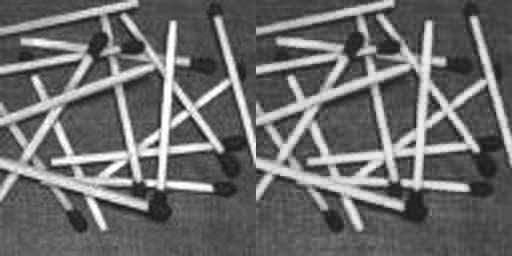

----------   PSNR: 31.120995952834516

--------------------------Mean PSNR of all images in epoch - 4 : 29.035567634609528-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 4 : 0.001969878215831371------------------
psnr change after an epoch (psnr - previous_psnr =): 0.6794936747770457

sample for epoch - 4
              Real                           predicted


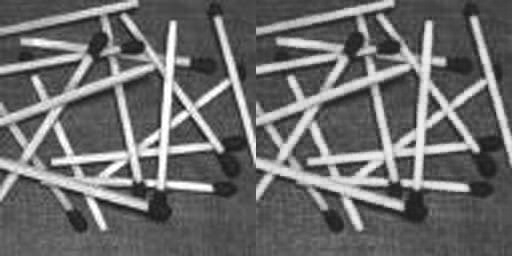

----------   PSNR: 32.12016807676416

--------------------------Mean PSNR of all images in epoch - 5 : 29.624790399212944-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 5 : 0.001767269705191578------------------
psnr change after an epoch (psnr - previous_psnr =): 0.5892227646034165

sample for epoch - 5
              Real                           predicted


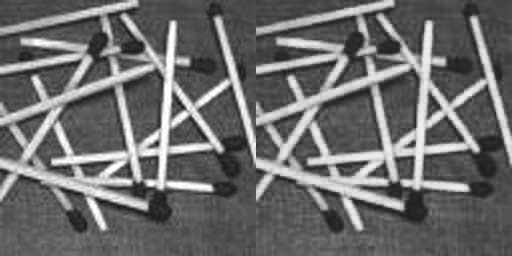

----------   PSNR: 32.945464830368174

--------------------------Mean PSNR of all images in epoch - 6 : 30.049772012799867-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 6 : 0.0016356798072329713------------------
psnr change after an epoch (psnr - previous_psnr =): 0.42498161358692244

sample for epoch - 6
              Real                           predicted


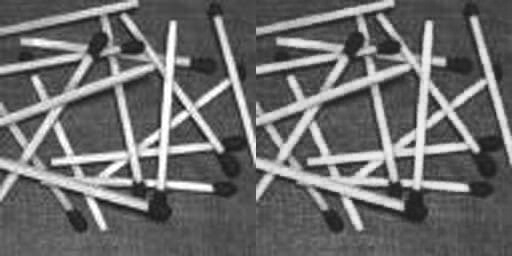

----------   PSNR: 33.4857826621065

--------------------------Mean PSNR of all images in epoch - 7 : 30.398994923616552-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 7 : 0.0015354431817429372------------------
psnr change after an epoch (psnr - previous_psnr =): 0.34922291081668533

sample for epoch - 7
              Real                           predicted


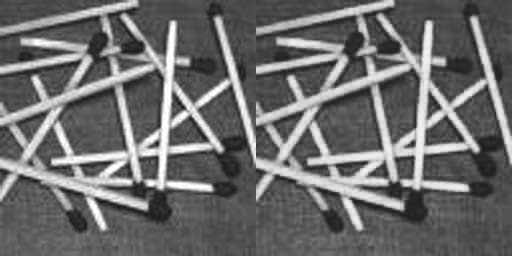

----------   PSNR: 33.881482269798695

--------------------------Mean PSNR of all images in epoch - 8 : 30.73749181590215-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 8 : 0.0014451770758732113------------------
psnr change after an epoch (psnr - previous_psnr =): 0.33849689228559754

sample for epoch - 8
              Real                           predicted


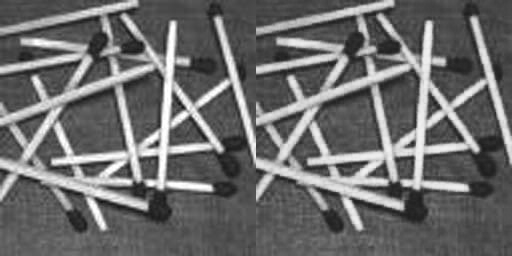

----------   PSNR: 34.222865531034394

--------------------------Mean PSNR of all images in epoch - 9 : 31.046845266524183-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 9 : 0.0013668875773753554------------------
psnr change after an epoch (psnr - previous_psnr =): 0.3093534506220337

sample for epoch - 9
              Real                           predicted


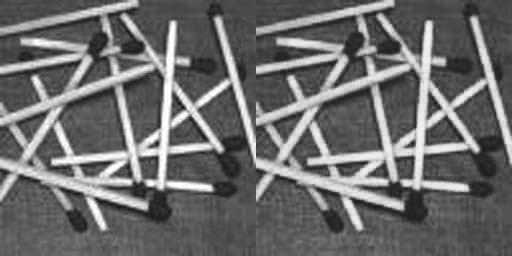

----------   PSNR: 34.482350580179606

--------------------------Mean PSNR of all images in epoch - 10 : 31.321881607880776-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 10 : 0.0013004871034528996------------------
psnr change after an epoch (psnr - previous_psnr =): 0.27503634135659283

sample for epoch - 10
              Real                           predicted


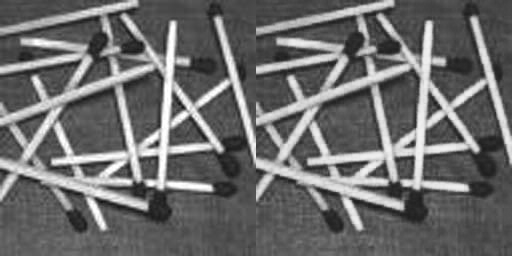

----------   PSNR: 34.70409032958311

--------------------------Mean PSNR of all images in epoch - 11 : 31.558515338021913-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 11 : 0.001245203582471402------------------
psnr change after an epoch (psnr - previous_psnr =): 0.2366337301411363

sample for epoch - 11
              Real                           predicted


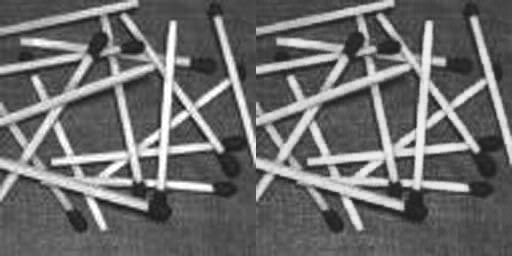

----------   PSNR: 34.89009433247584

--------------------------Mean PSNR of all images in epoch - 12 : 31.76340371827021-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 12 : 0.0011984567542601358------------------
psnr change after an epoch (psnr - previous_psnr =): 0.20488838024829903

sample for epoch - 12
              Real                           predicted


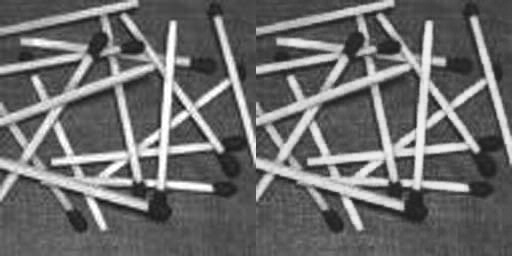

----------   PSNR: 35.046081511765536

--------------------------Mean PSNR of all images in epoch - 13 : 31.945394093365085-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 13 : 0.0011578137773560905------------------
psnr change after an epoch (psnr - previous_psnr =): 0.18199037509487326

sample for epoch - 13
              Real                           predicted


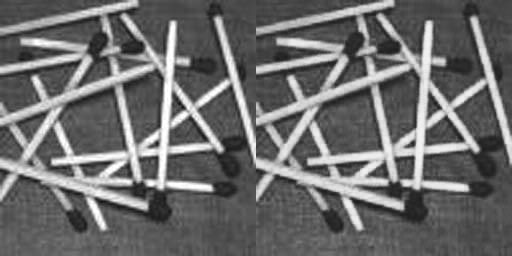

----------   PSNR: 35.17961987799746

--------------------------Mean PSNR of all images in epoch - 14 : 32.11107831709499-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 14 : 0.0011216274506988917------------------
psnr change after an epoch (psnr - previous_psnr =): 0.1656842237299081

sample for epoch - 14
              Real                           predicted


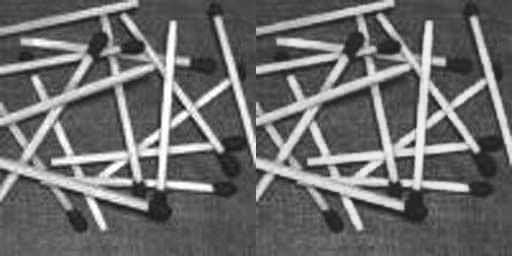

----------   PSNR: 35.296953588516004

--------------------------Mean PSNR of all images in epoch - 15 : 32.266436706236405-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 15 : 0.0010885412194845641------------------
psnr change after an epoch (psnr - previous_psnr =): 0.1553583891414121

sample for epoch - 15
              Real                           predicted


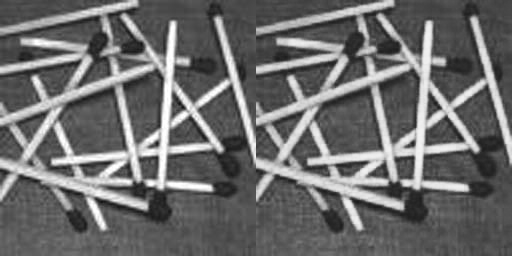

----------   PSNR: 35.40457017950278

--------------------------Mean PSNR of all images in epoch - 16 : 32.41599800523261-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 16 : 0.001057561887218421------------------
psnr change after an epoch (psnr - previous_psnr =): 0.14956129899620407

sample for epoch - 16
              Real                           predicted


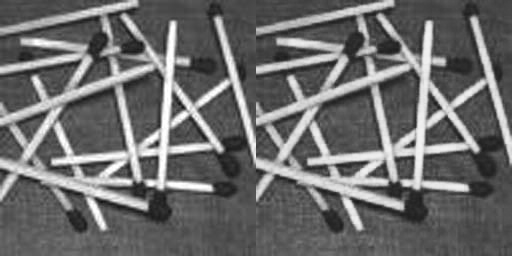

----------   PSNR: 35.506969948216

--------------------------Mean PSNR of all images in epoch - 17 : 32.56194144162768-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 17 : 0.0010281703606213237------------------
psnr change after an epoch (psnr - previous_psnr =): 0.145943436395072

sample for epoch - 17
              Real                           predicted


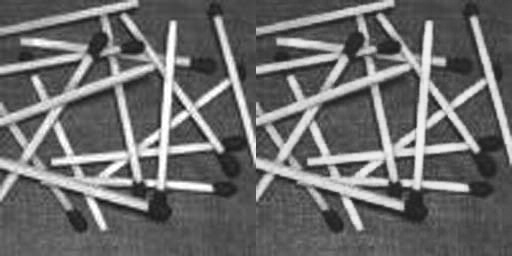

----------   PSNR: 35.60533013222867

--------------------------Mean PSNR of all images in epoch - 18 : 32.70447250801841-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 18 : 0.001000233852894598------------------
psnr change after an epoch (psnr - previous_psnr =): 0.1425310663907311

sample for epoch - 18
              Real                           predicted


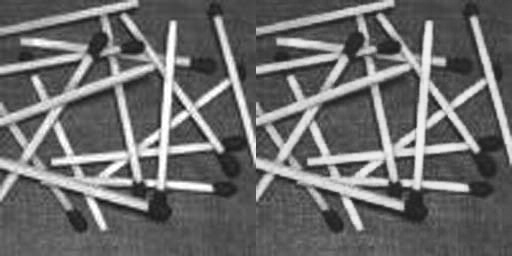

----------   PSNR: 35.69856352180375

--------------------------Mean PSNR of all images in epoch - 19 : 32.84237913943247-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 19 : 0.0009739002922154863------------------
psnr change after an epoch (psnr - previous_psnr =): 0.13790663141405446

sample for epoch - 19
              Real                           predicted


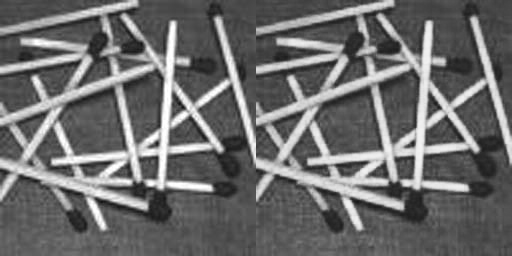

----------   PSNR: 35.78478375156093

--------------------------Mean PSNR of all images in epoch - 20 : 32.97352960652894-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 20 : 0.0009494905287761276------------------
psnr change after an epoch (psnr - previous_psnr =): 0.13115046709647515

sample for epoch - 20
              Real                           predicted


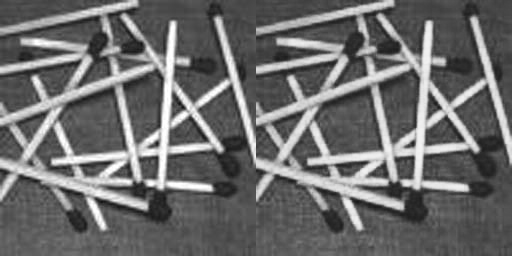

----------   PSNR: 35.86227478314148



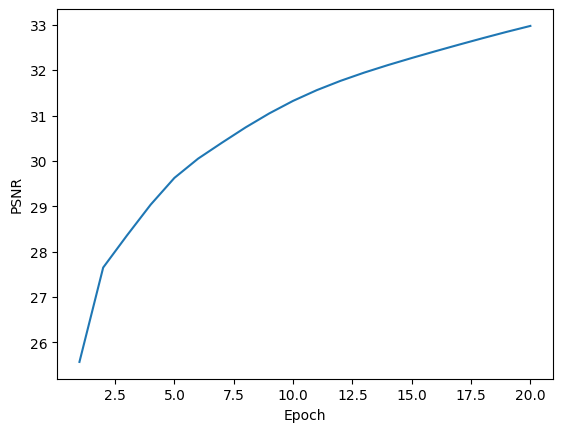


*******************End of epochs*********************
Durationt:  177.84982323646545  seconds



In [ ]:
model = AutoencoderMLP(n_input=64, n_hidden=32, n_output=64, alpha=0.01, optimizer='SGD')
model.train(X_train, max_epochs=20, Mean_PSNR_minChange=0.1, Mean_PSNR_Max=40)

Mean PSNR of test images: 36.95118849631747 - Mean MSE of test images: 0.00022887186014617739
              Real                           predicted


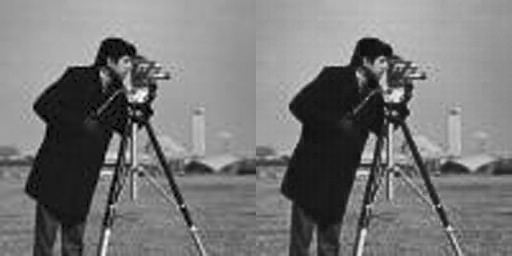

----------   PSNR: 38.494067028819714



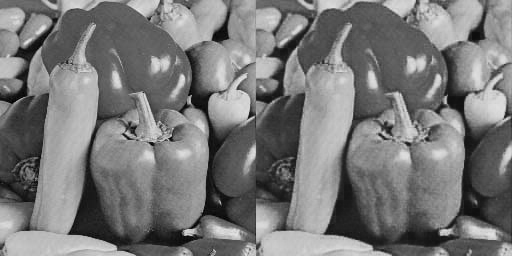

----------   PSNR: 34.50000698035359



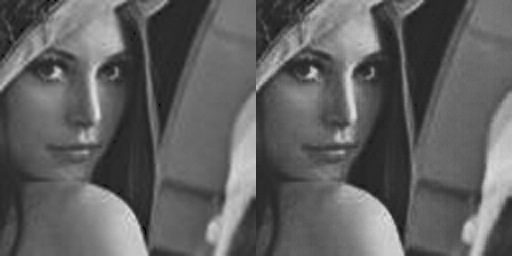

----------   PSNR: 40.73462644341606



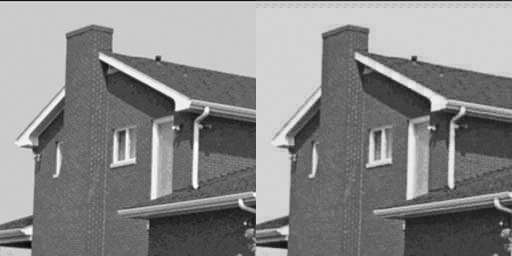

----------   PSNR: 35.17092769312738



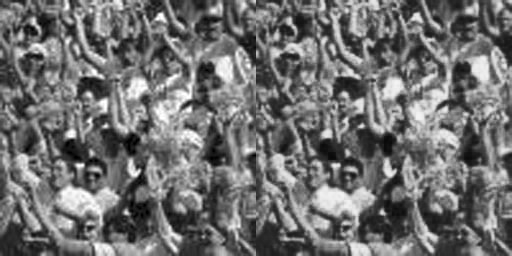

----------   PSNR: 35.856314335870614



In [ ]:
Mean_PSNR, Mean_MSE, eval_info_list = model.evaluate(X_test)
print(f"Mean PSNR of test images: {Mean_PSNR} - Mean MSE of test images: {Mean_MSE}")
model.ShowResultImages(eval_info_list)

## **Training & testing model with 16 hidden nerouns**

--------------------------Mean PSNR of all images in epoch - 1 : 25.03765957762709-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 1 : 0.004335544583016501------------------
psnr change after an epoch (psnr - previous_psnr =): 25.03765957762709

sample for epoch - 1
              Real                           predicted


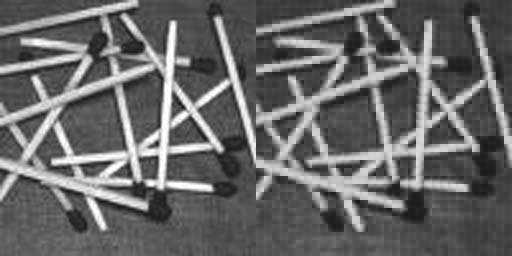

----------   PSNR: 24.794740073000746

--------------------------Mean PSNR of all images in epoch - 2 : 26.697781524634493-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 2 : 0.0030961025728731364------------------
psnr change after an epoch (psnr - previous_psnr =): 1.6601219470074042

sample for epoch - 2
              Real                           predicted


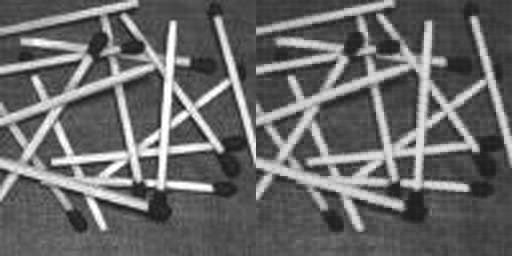

----------   PSNR: 27.611899212265683

--------------------------Mean PSNR of all images in epoch - 3 : 27.619520631319585-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 3 : 0.0025955129944231197------------------
psnr change after an epoch (psnr - previous_psnr =): 0.9217391066850915

sample for epoch - 3
              Real                           predicted


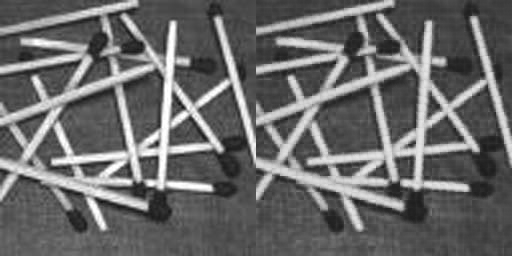

----------   PSNR: 29.3042498968453

--------------------------Mean PSNR of all images in epoch - 4 : 28.224862280563563-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 4 : 0.0023187910724757144------------------
psnr change after an epoch (psnr - previous_psnr =): 0.6053416492439787

sample for epoch - 4
              Real                           predicted


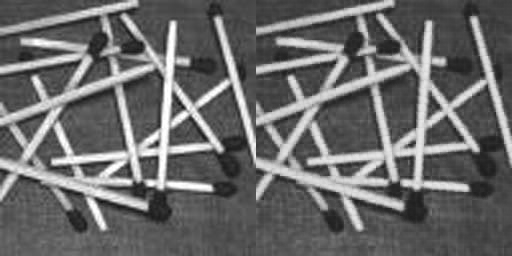

----------   PSNR: 30.392629605067096

--------------------------Mean PSNR of all images in epoch - 5 : 28.69806156504695-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 5 : 0.002123378393558914------------------
psnr change after an epoch (psnr - previous_psnr =): 0.47319928448338544

sample for epoch - 5
              Real                           predicted


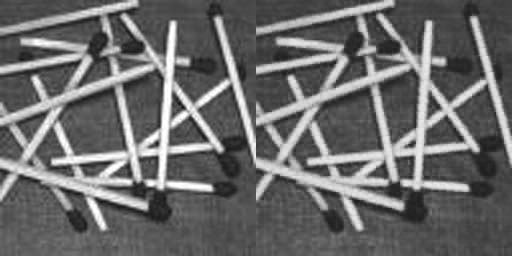

----------   PSNR: 31.214209155666953

--------------------------Mean PSNR of all images in epoch - 6 : 29.04668425927507-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 6 : 0.0019890076627548693------------------
psnr change after an epoch (psnr - previous_psnr =): 0.34862269422812275

sample for epoch - 6
              Real                           predicted


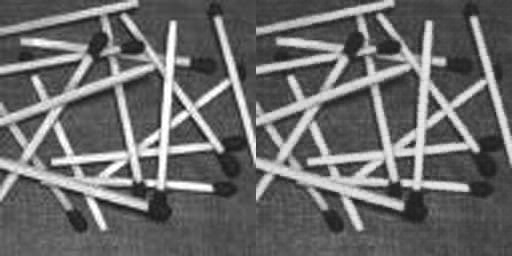

----------   PSNR: 31.808454425037386

--------------------------Mean PSNR of all images in epoch - 7 : 29.29017373403083-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 7 : 0.0018986776360491323------------------
psnr change after an epoch (psnr - previous_psnr =): 0.24348947475575855

sample for epoch - 7
              Real                           predicted


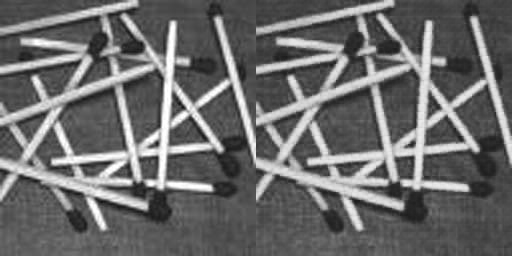

----------   PSNR: 32.21882758705221

--------------------------Mean PSNR of all images in epoch - 8 : 29.47909718683567-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 8 : 0.001830407606492937------------------
psnr change after an epoch (psnr - previous_psnr =): 0.1889234528048398

sample for epoch - 8
              Real                           predicted


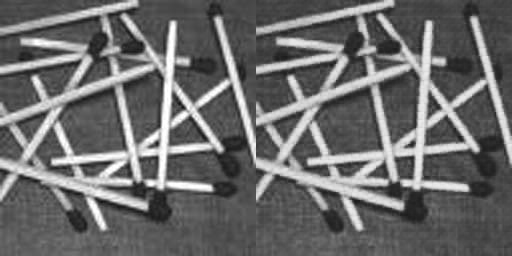

----------   PSNR: 32.52277491217544

--------------------------Mean PSNR of all images in epoch - 9 : 29.65383090400669-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 9 : 0.0017696471888496749------------------
psnr change after an epoch (psnr - previous_psnr =): 0.17473371717101926

sample for epoch - 9
              Real                           predicted


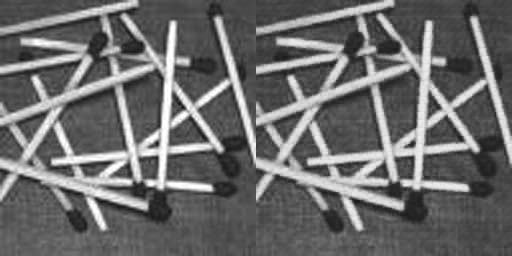

----------   PSNR: 32.78305417680056

--------------------------Mean PSNR of all images in epoch - 10 : 29.820169780432714-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 10 : 0.001714140352706467------------------
psnr change after an epoch (psnr - previous_psnr =): 0.16633887642602474

sample for epoch - 10
              Real                           predicted


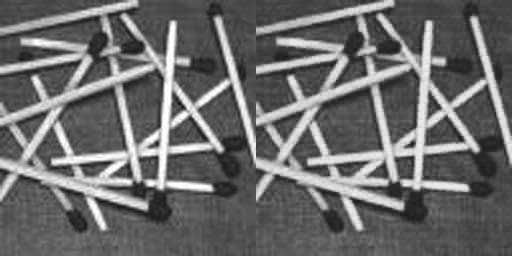

----------   PSNR: 33.01457625532153



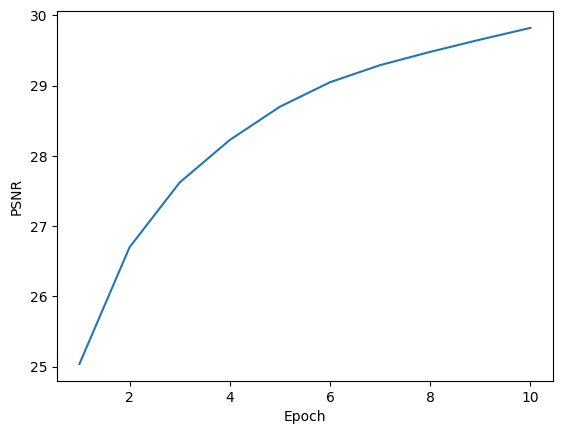


*******************End of epochs*********************
Durationt:  80.77821683883667  seconds



In [ ]:
model = AutoencoderMLP(n_input=64, n_hidden=16, n_output=64, alpha=0.01, optimizer='SGD')
model.train(X_train, max_epochs=10, Mean_PSNR_minChange=0.1, Mean_PSNR_Max=40)

Mean PSNR of test images: 32.94439452931225 - Mean MSE of test images: 0.0005490257670663857
              Real                           predicted


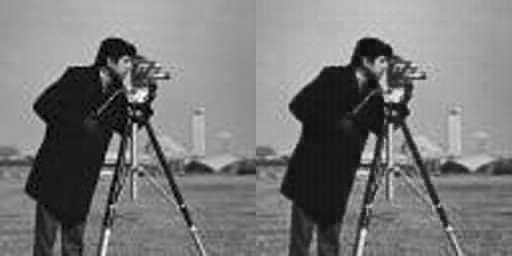

----------   PSNR: 33.251747031501885



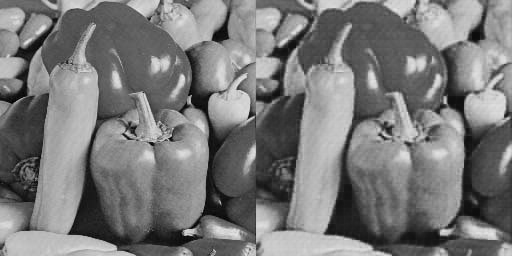

----------   PSNR: 30.82338019826384



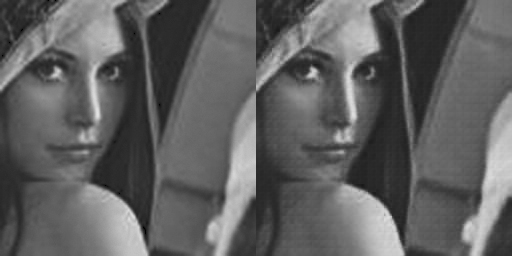

----------   PSNR: 36.2675030637328



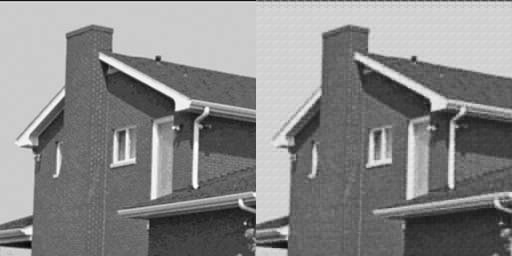

----------   PSNR: 32.04208686251363



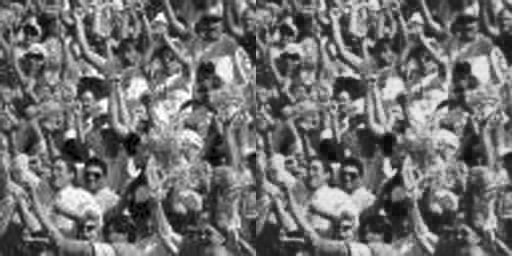

----------   PSNR: 32.337255490549104



In [ ]:
Mean_PSNR, Mean_MSE, eval_info_list = model.evaluate(X_test)
print(f"Mean PSNR of test images: {Mean_PSNR} - Mean MSE of test images: {Mean_MSE}")
model.ShowResultImages(eval_info_list)

## **Training & testing model with 4 hidden nerouns**

--------------------------Mean PSNR of all images in epoch - 1 : 24.177473071617488-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 1 : 0.005204390231292788------------------
psnr change after an epoch (psnr - previous_psnr =): 24.177473071617488

sample for epoch - 1
              Real                           predicted


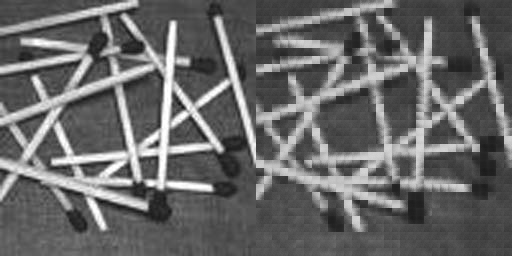

----------   PSNR: 23.28843328733736

--------------------------Mean PSNR of all images in epoch - 2 : 24.952668023053945-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 2 : 0.004423156435614764------------------
psnr change after an epoch (psnr - previous_psnr =): 0.7751949514364576

sample for epoch - 2
              Real                           predicted


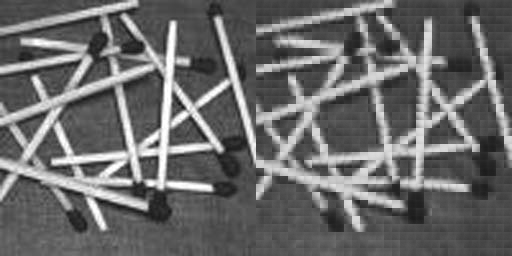

----------   PSNR: 24.671903844649524

--------------------------Mean PSNR of all images in epoch - 3 : 25.178556775071602-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 3 : 0.004203624448758569------------------
psnr change after an epoch (psnr - previous_psnr =): 0.22588875201765646

sample for epoch - 3
              Real                           predicted


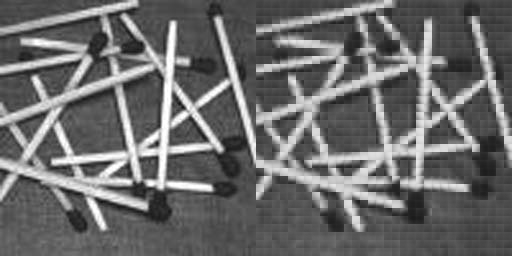

----------   PSNR: 25.13669415866762

--------------------------Mean PSNR of all images in epoch - 4 : 25.296610694749322-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 4 : 0.004093886945606838------------------
psnr change after an epoch (psnr - previous_psnr =): 0.11805391967772039

sample for epoch - 4
              Real                           predicted


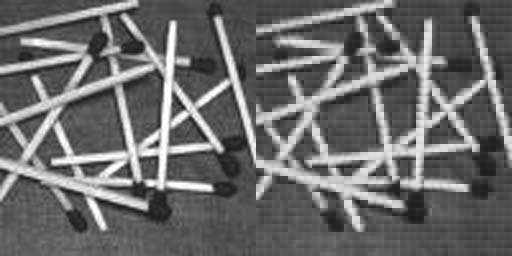

----------   PSNR: 25.367784051110718

--------------------------Mean PSNR of all images in epoch - 5 : 25.37604066342752-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 5 : 0.0040234096761472896------------------
psnr change after an epoch (psnr - previous_psnr =): 0.07942996867819829

sample for epoch - 5
              Real                           predicted


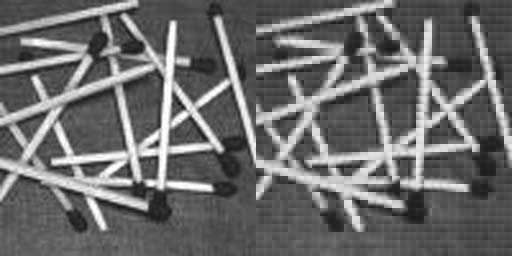

----------   PSNR: 25.510737622991204

No considerable change!


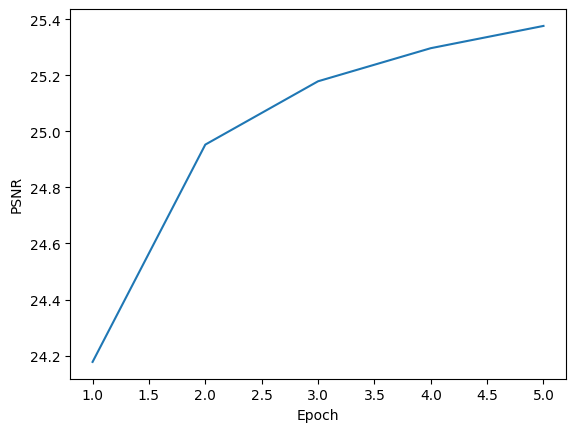


*******************End of epochs*********************
Durationt:  39.11247181892395  seconds



In [ ]:
model = AutoencoderMLP(n_input=64, n_hidden=4, n_output=64, alpha=0.01, optimizer='SGD')
model.train(X_train, max_epochs=10, Mean_PSNR_minChange=0.1, Mean_PSNR_Max=40)

Mean PSNR of test images: 27.292334855437748 - Mean MSE of test images: 0.0021318270747465694
              Real                           predicted


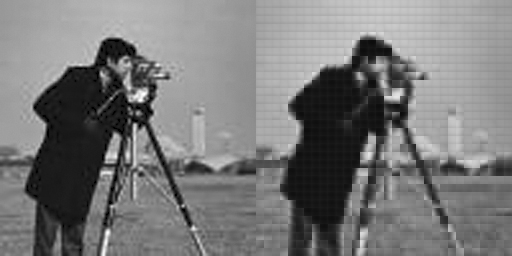

----------   PSNR: 27.802468679337764



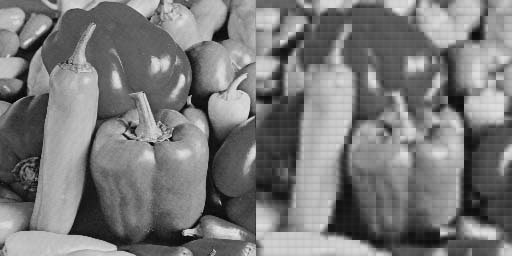

----------   PSNR: 26.381126285342905



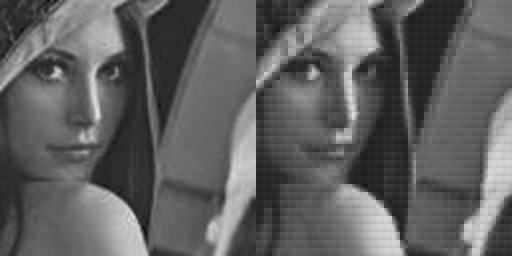

----------   PSNR: 31.658085594002195



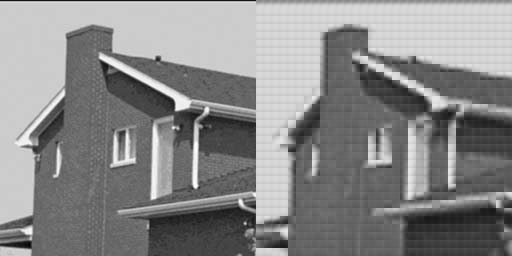

----------   PSNR: 26.214426871108543



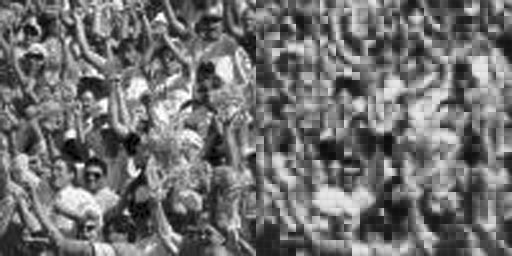

----------   PSNR: 24.405566847397317



In [ ]:
Mean_PSNR, Mean_MSE, eval_info_list = model.evaluate(X_test)
print(f"Mean PSNR of test images: {Mean_PSNR} - Mean MSE of test images: {Mean_MSE}")
model.ShowResultImages(eval_info_list)

In [ ]:
# *****************************************************************************************************************

# **Optimizer: Momentum**

---



## **Training & testing model with 32 hidden nerouns**


--------------------------Mean PSNR of all images in epoch - 1 : 27.88577926537458-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 1 : 0.0021746049519158757------------------
psnr change after an epoch (psnr - previous_psnr =): 27.88577926537458

sample for epoch - 1
              Real                           predicted


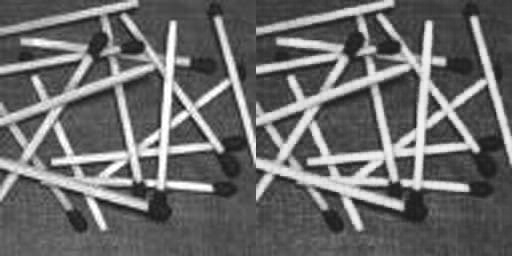

----------   PSNR: 29.916856855472357

--------------------------Mean PSNR of all images in epoch - 2 : 29.999080228512362-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 2 : 0.001466383024785124------------------
psnr change after an epoch (psnr - previous_psnr =): 2.1133009631377817

sample for epoch - 2
              Real                           predicted


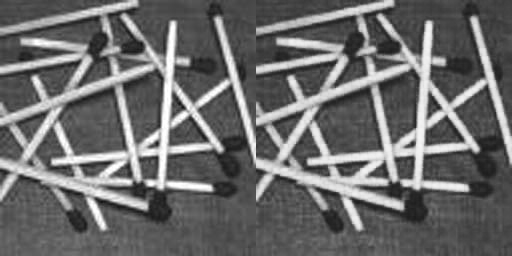

----------   PSNR: 32.34547715253627

--------------------------Mean PSNR of all images in epoch - 3 : 31.26634473332657-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 3 : 0.0011514819851409324------------------
psnr change after an epoch (psnr - previous_psnr =): 1.2672645048142073

sample for epoch - 3
              Real                           predicted


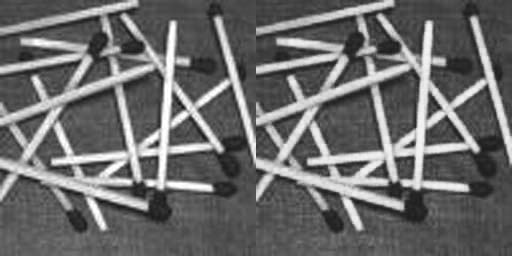

----------   PSNR: 33.41950318336824

--------------------------Mean PSNR of all images in epoch - 4 : 31.847498821061137-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 4 : 0.0010050533637762141------------------
psnr change after an epoch (psnr - previous_psnr =): 0.5811540877345678

sample for epoch - 4
              Real                           predicted


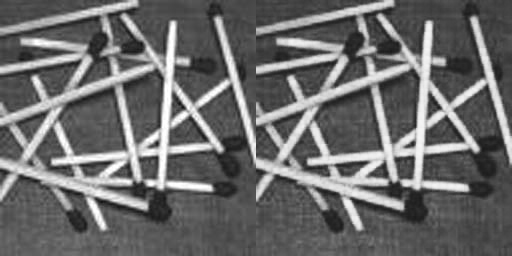

----------   PSNR: 33.510510591971624

--------------------------Mean PSNR of all images in epoch - 5 : 32.083746458083226-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 5 : 0.0009326037386578405------------------
psnr change after an epoch (psnr - previous_psnr =): 0.23624763702208895

sample for epoch - 5
              Real                           predicted


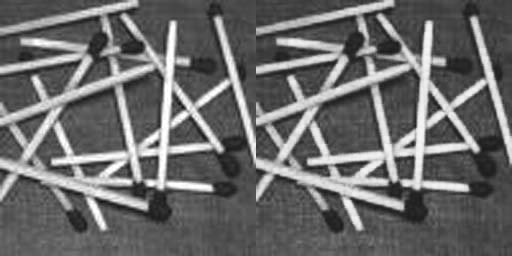

----------   PSNR: 33.24291377356766

--------------------------Mean PSNR of all images in epoch - 6 : 32.157841038375125-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 6 : 0.0008979388577765909------------------
psnr change after an epoch (psnr - previous_psnr =): 0.07409458029189864

sample for epoch - 6
              Real                           predicted


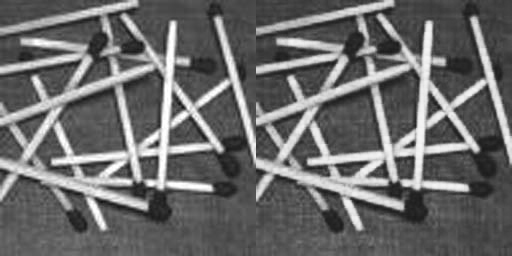

----------   PSNR: 32.89012924794413

No considerable change!


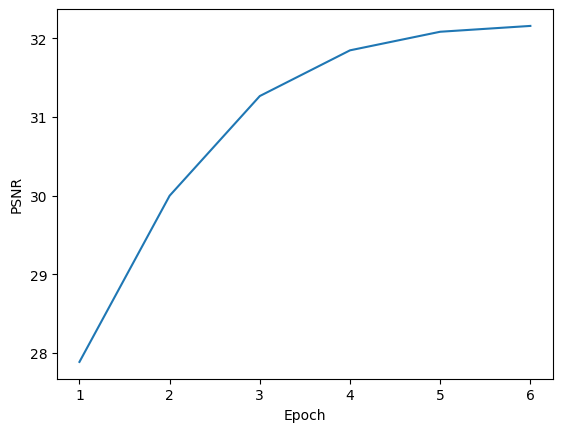


*******************End of epochs*********************
Durationt:  58.22738337516785  seconds



In [ ]:
model = AutoencoderMLP(n_input=64, n_hidden=32, n_output=64, alpha=0.01, optimizer='momentum')
model.train(X_train, max_epochs=10, Mean_PSNR_minChange=0.1, Mean_PSNR_Max=40)

Mean PSNR of test images: 34.24684018198744 - Mean MSE of test images: 0.0003927211864622621
              Real                           predicted


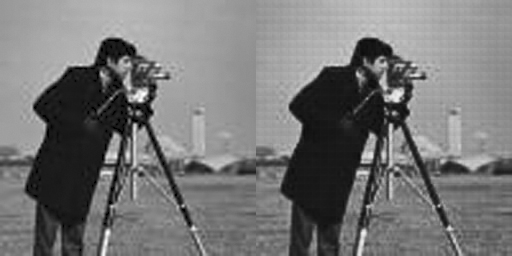

----------   PSNR: 36.56443442800641



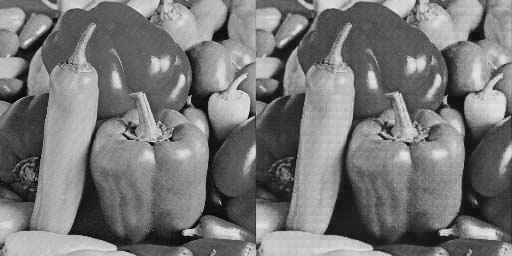

----------   PSNR: 33.361530573624314



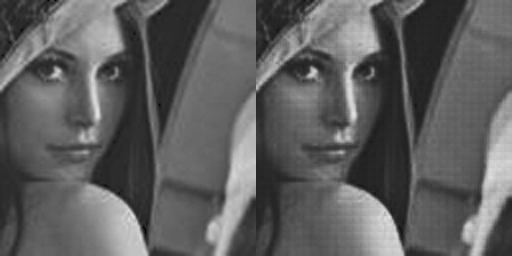

----------   PSNR: 34.70151693421293



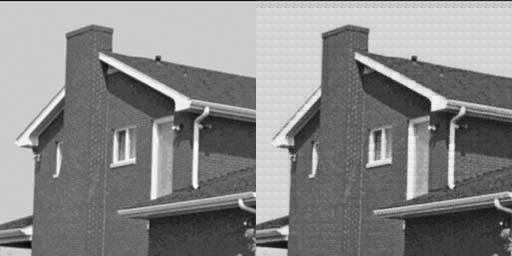

----------   PSNR: 32.72146369927556



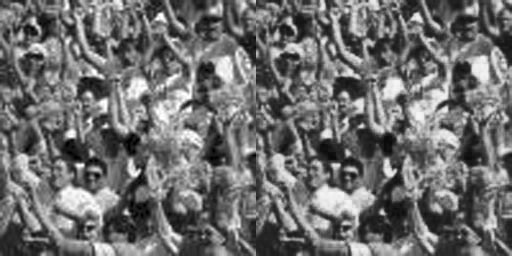

----------   PSNR: 33.88525527481797



In [ ]:
Mean_PSNR, Mean_MSE, eval_info_list = model.evaluate(X_test)
print(f"Mean PSNR of test images: {Mean_PSNR} - Mean MSE of test images: {Mean_MSE}")
model.ShowResultImages(eval_info_list)

## **Training & testing model with 16 hidden nerouns**

--------------------------Mean PSNR of all images in epoch - 1 : 27.42563676077119-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 1 : 0.0024824193897682737------------------
psnr change after an epoch (psnr - previous_psnr =): 27.42563676077119

sample for epoch - 1
              Real                           predicted


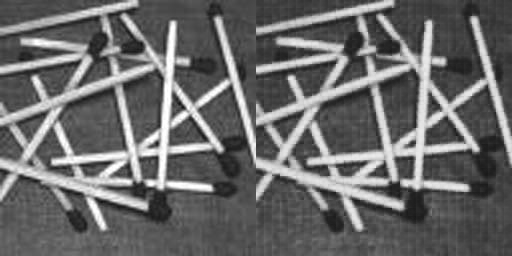

----------   PSNR: 29.303454818610927

--------------------------Mean PSNR of all images in epoch - 2 : 28.417751090322096-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 2 : 0.002033819811517517------------------
psnr change after an epoch (psnr - previous_psnr =): 0.9921143295509047

sample for epoch - 2
              Real                           predicted


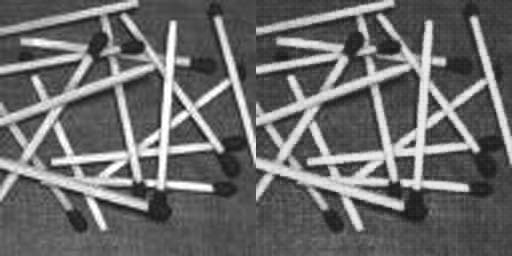

----------   PSNR: 30.93038527341868

--------------------------Mean PSNR of all images in epoch - 3 : 28.777234594287226-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 3 : 0.001893127454436149------------------
psnr change after an epoch (psnr - previous_psnr =): 0.35948350396513007

sample for epoch - 3
              Real                           predicted


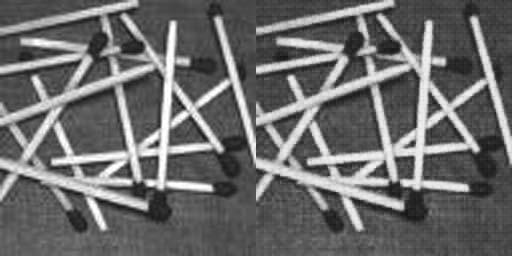

----------   PSNR: 31.612422732720823

--------------------------Mean PSNR of all images in epoch - 4 : 29.051848461682287-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 4 : 0.0017928891126247778------------------
psnr change after an epoch (psnr - previous_psnr =): 0.2746138673950611

sample for epoch - 4
              Real                           predicted


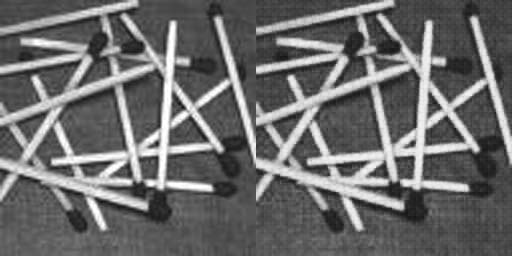

----------   PSNR: 31.74419137924005

--------------------------Mean PSNR of all images in epoch - 5 : 29.149688178778764-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 5 : 0.0017467272459292971------------------
psnr change after an epoch (psnr - previous_psnr =): 0.09783971709647687

sample for epoch - 5
              Real                           predicted


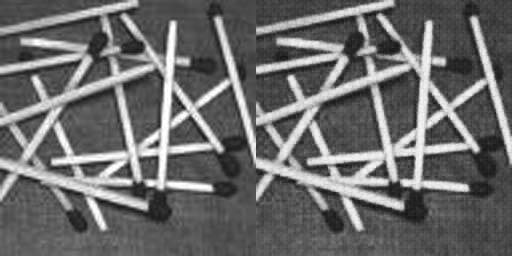

----------   PSNR: 31.43576598684968

No considerable change!


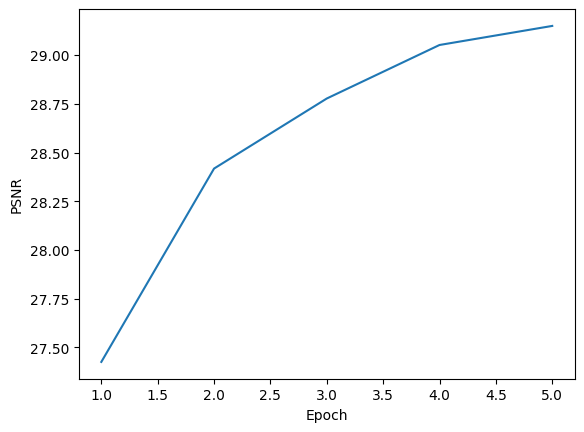


*******************End of epochs*********************
Durationt:  46.21676325798035  seconds



In [ ]:
model = AutoencoderMLP(n_input=64, n_hidden=16, n_output=64, alpha=0.01, optimizer='momentum')
model.train(X_train, max_epochs=10, Mean_PSNR_minChange=0.1, Mean_PSNR_Max=40)

Mean PSNR of test images: 30.990586718090828 - Mean MSE of test images: 0.0008292536911772026
              Real                           predicted


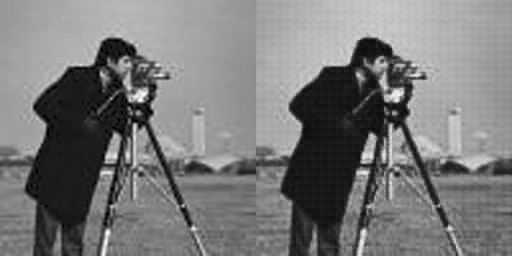

----------   PSNR: 31.225234915227652



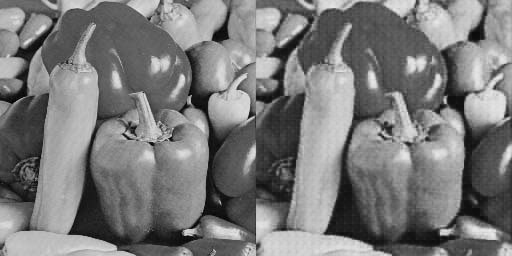

----------   PSNR: 29.35970511048965



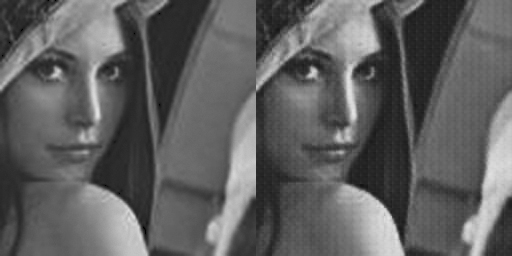

----------   PSNR: 33.14815871567432



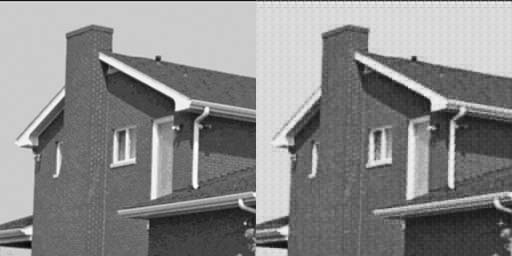

----------   PSNR: 30.12381096384507



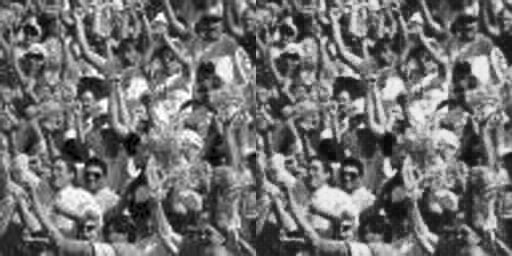

----------   PSNR: 31.096023885217456



In [ ]:
Mean_PSNR, Mean_MSE, eval_info_list = model.evaluate(X_test)
print(f"Mean PSNR of test images: {Mean_PSNR} - Mean MSE of test images: {Mean_MSE}")
model.ShowResultImages(eval_info_list)

## **Training & testing model with 4 hidden nerouns**

--------------------------Mean PSNR of all images in epoch - 1 : 23.945096825325486-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 1 : 0.005016519856852289------------------
psnr change after an epoch (psnr - previous_psnr =): 23.945096825325486

sample for epoch - 1
              Real                           predicted


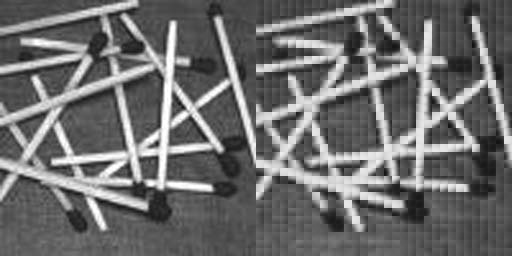

----------   PSNR: 24.82555778209892

--------------------------Mean PSNR of all images in epoch - 2 : 23.049144347988577-----------------------------------
------------Mean MSE(mean squared error of all pixcels of an image) of all images in epoch - 2 : 0.00593073777359551------------------
psnr change after an epoch (psnr - previous_psnr =): -0.895952477336909

sample for epoch - 2
              Real                           predicted


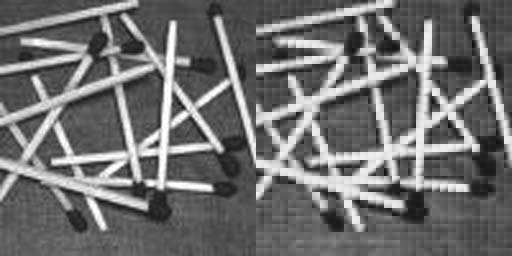

----------   PSNR: 24.252435367865573

No considerable change!


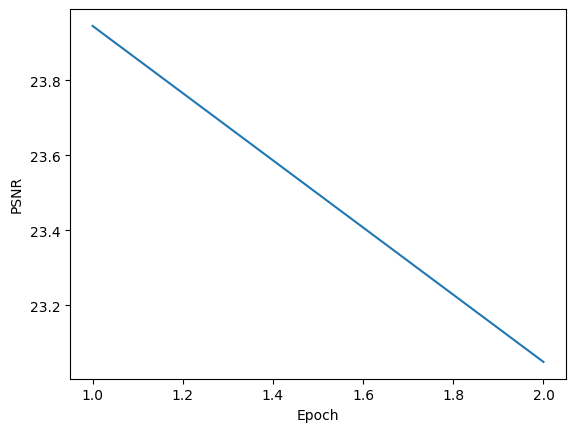


*******************End of epochs*********************
Durationt:  17.334864616394043  seconds



In [ ]:
model = AutoencoderMLP(n_input=64, n_hidden=4, n_output=64, alpha=0.01, optimizer='momentum')
model.train(X_train, max_epochs=10, Mean_PSNR_minChange=0.1, Mean_PSNR_Max=40)

Mean PSNR of test images: 23.3321414262661 - Mean MSE of test images: 0.004895651399797587
              Real                           predicted


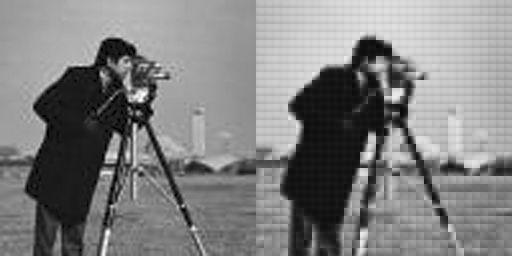

----------   PSNR: 22.246144678952522



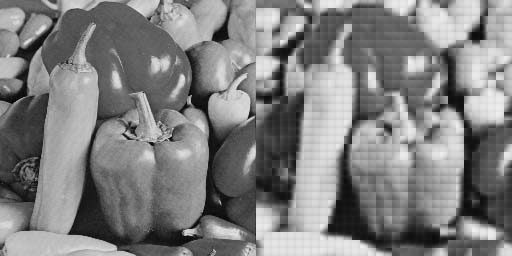

----------   PSNR: 22.570212390756886



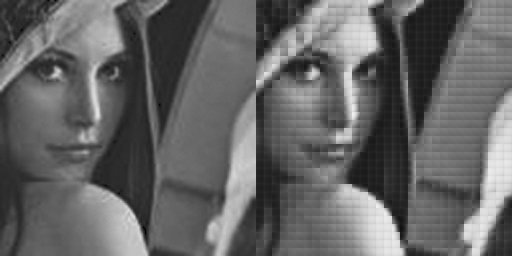

----------   PSNR: 26.34353865855296



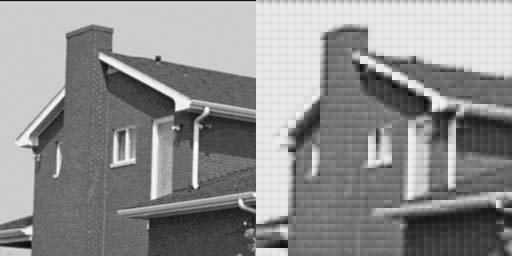

----------   PSNR: 23.15266169675749



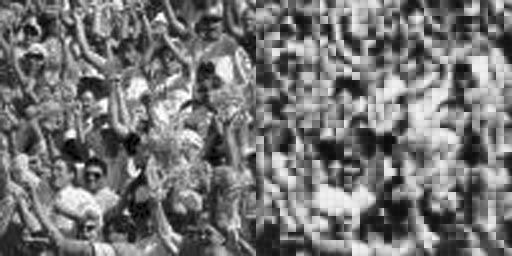

----------   PSNR: 22.348149706310654



In [ ]:
Mean_PSNR, Mean_MSE, eval_info_list = model.evaluate(X_test)
print(f"Mean PSNR of test images: {Mean_PSNR} - Mean MSE of test images: {Mean_MSE}")
model.ShowResultImages(eval_info_list)